### <center style='color:salmon'>`Artificial Neural Network (ANN)` for regression task - Example using sklearn's `california housing` dataset</center>

# 1. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 2. Load `california housing` dataset

In [2]:
class CaliforniaHousingDataset(Dataset):
    def __init__(self, X, y, scale_data=True):
        
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [3]:
X, y = datasets.fetch_california_housing(return_X_y=True)

In [4]:
dataset = CaliforniaHousingDataset(X, y)

In [5]:
X.shape, y.shape

((20640, 8), (20640,))

# 3. Define dataloaders

In [6]:
dataloader = DataLoader(dataset, batch_size=12, shuffle=True)

In [7]:
len(dataloader)

1720

# 4. Define the network architecture 

In [8]:
class ANN_Regression(nn.Module):
    def __init__(self):
        super(ANN_Regression, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_features=8, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1)
        )
        
    def forward(self, x):
        return self.model(x)

# 5. Visualize the network architecture

In [9]:
summary(ANN_Regression(), input_size=(12, 8))

Layer (type:depth-idx)                   Output Shape              Param #
ANN_Regression                           [12, 1]                   --
├─Sequential: 1-1                        [12, 1]                   --
│    └─Linear: 2-1                       [12, 64]                  576
│    └─ReLU: 2-2                         [12, 64]                  --
│    └─Linear: 2-3                       [12, 32]                  2,080
│    └─ReLU: 2-4                         [12, 32]                  --
│    └─Linear: 2-5                       [12, 1]                   33
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

# 6. Define the training batch

In [10]:
def training_batch(data, targets, model, criterion, optimizer):
    model.train()
    output = model(data)
    loss = criterion(output, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

# 7. Set up model, criterion and optimizer

In [11]:
model = ANN_Regression()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 8. Train the model

In [12]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.random.manual_seed(42)

n_epochs = 100

loss = []

for epoch in range(n_epochs):
    
    losses = []
    
    for data, targets in dataloader:
        data, targets = data.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        trng_batch_loss = training_batch(data, targets, model, criterion, optimizer)
        losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(losses).mean()
    
    loss.append(training_per_epoch_loss)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t|  Training loss: {training_per_epoch_loss:.4f}')

Epoch: 10/100	|  Training loss: 0.3882
Epoch: 20/100	|  Training loss: 0.3733
Epoch: 30/100	|  Training loss: 0.3673
Epoch: 40/100	|  Training loss: 0.3673
Epoch: 50/100	|  Training loss: 0.3591
Epoch: 60/100	|  Training loss: 0.3566
Epoch: 70/100	|  Training loss: 0.3552
Epoch: 80/100	|  Training loss: 0.3553
Epoch: 90/100	|  Training loss: 0.3542
Epoch: 100/100	|  Training loss: 0.3494


# 9. Plot training loss

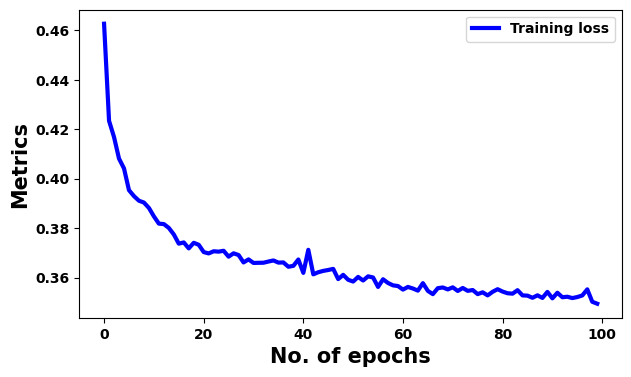

In [13]:
plt.figure(figsize=(7, 4))
plt.plot(loss, linewidth=3, color='b', label='Training loss')
plt.xlabel('No. of epochs', fontsize=15, fontweight='bold')
plt.ylabel('Metrics', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(prop={'weight': 'bold'});

# 10. Model prediction

In [14]:
features, actual_targets = next(iter(dataloader))

In [15]:
model.eval()
predicted_targets = model(features.float())
predicted_targets

tensor([[1.2397],
        [1.2168],
        [2.4271],
        [0.6459],
        [3.0935],
        [1.7537],
        [1.3481],
        [0.6476],
        [0.8132],
        [4.4577],
        [1.4132],
        [2.6655]], grad_fn=<AddmmBackward0>)

In [16]:
actual_targets

tensor([1.9930, 1.3210, 2.6960, 1.0420, 3.8120, 1.6470, 1.1930, 0.8410, 0.8890,
        3.9090, 1.3710, 2.8940], dtype=torch.float64)

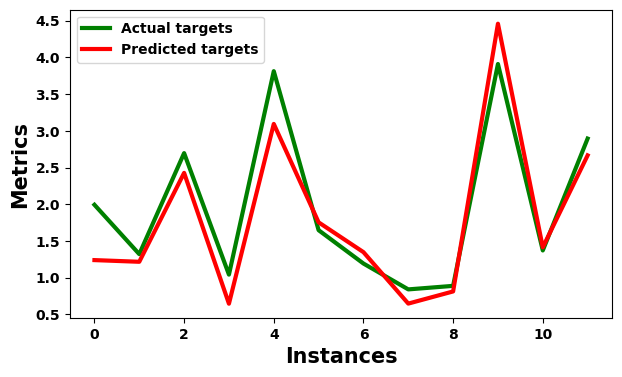

In [17]:
plt.figure(figsize=(7, 4))
plt.plot(actual_targets, linewidth=3, color='g', label='Actual targets')
plt.plot(predicted_targets.detach(), linewidth=3, color='r', label='Predicted targets')
plt.xlabel('Instances', fontsize=15, fontweight='bold')
plt.ylabel('Metrics', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(prop={'weight': 'bold'});